In [1]:
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from sklearn.datasets import load_iris

In [2]:
# banknote authentication Data Set
# https://archive.ics.uci.edu/ml/datasets/banknote+authentication
# Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml].
# Irvine, CA: University of California, School of Information and Computer Science.

""" data_file = "data_banknote_authentication.csv"
banknote_data = pd.read_csv(data_file)
banknote_data = banknote_data.replace(',', '.', regex=True).astype(float)
data_x = banknote_data.drop(columns=['class']).values
data_y = banknote_data['class'].values """

data_x, data_y = load_iris(return_X_y=True)
data_x[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [3]:
# train and test split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) # check the shapes

(120, 4) (120,) (30, 4) (30,)


In [4]:
# Helper functions

# Data Normalisation
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

# Euclidean distance
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance:
        shortest_distance = distance
        winner = [row,col]
  return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [5]:
# hyperparameters
num_rows = 10
num_cols = 10
max_m_dsitance = 3
max_learning_rate = 0.5
max_steps = int(7.5*10e3)

# num_nurons = 5*np.sqrt(train_x.shape[0])
# grid_size = ceil(np.sqrt(num_nurons))
# print(grid_size)

In [6]:
#mian function

def train(train_x, map_size, max_learning_rate, n_iterations, sigma_0, show_progress_each=None):
  num_rows = num_cols = map_size
  train_x_norm = minmax_scaler(train_x) # normalisation

  # initialising self-organising map
  num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
  np.random.seed(40)
  som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

  # start training iterations
  for step in range(n_iterations):
    if (show_progress_each is not None) and ((step+1) % show_progress_each == 0):
      print("Iteration: ", step+1) # print out the current iteration for every 1k
    learning_rate, neighbourhood_range = decay(step, n_iterations, max_learning_rate, sigma_0)

    t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    for row in range(num_rows):
      for col in range(num_cols):
        if m_distance([row,col],winner) <= neighbourhood_range:
          som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

  print("SOM training completed")
  return som, train_x_norm

In [7]:
# collecting labels

def collect_labels(train_y, map_size, train_x_norm, som):
  num_rows = num_cols = map_size
  label_data = train_y
  map = np.empty(shape=(num_rows, num_cols), dtype=object)

  for row in range(num_rows):
    for col in range(num_cols):
      map[row][col] = [] # empty list to store the label

  for t in range(train_x_norm.shape[0]):
    if (t+1) % 1000 == 0:
      print("sample data: ", t+1)
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron
  
  return map


In [8]:
# construct label map

def get_label_map(map_size, map,):
  num_rows = num_cols = map_size
  label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
  for row in range(num_rows):
    for col in range(num_cols):
      label_list = map[row][col]
      if len(label_list)==0:
        label = 2
      else:
        label = max(label_list, key=label_list.count)
      label_map[row][col] = label
  return label_map

def show_label_map(label_map, max_steps):
  title = ('Iteration ' + str(max_steps))
  cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
  plt.imshow(label_map, cmap=cmap)
  plt.colorbar()
  plt.title(title)
  plt.show()

In [9]:
# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

def accuracy(test_x, som, map_size, label_map):
    num_rows = num_cols = map_size
    data = minmax_scaler(test_x) # normalisation

    winner_labels = []

    for t in range(data.shape[0]):
        winner = winning_neuron(data, t, som, num_rows, num_cols)
        row = winner[0]
        col = winner[1]
        predicted = label_map[row][col]
        winner_labels.append(predicted)

    accu = accuracy_score(test_y, np.array(winner_labels))
    print("Accuracy: ", accu)
    return accu

Experiment 1:
	Map Size: 5
	Max Learning Rate: 0.5
	Number of Iterations: 1000
	Sigma_0: 3
SOM training completed


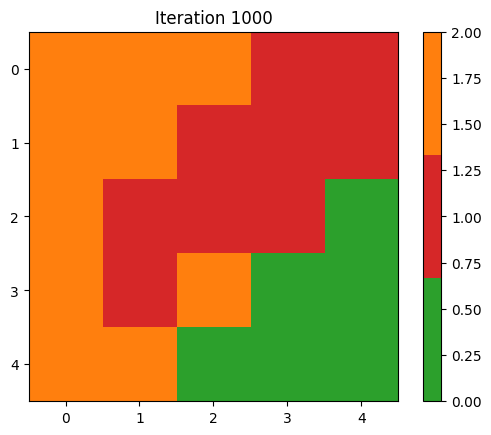

Accuracy:  0.9666666666666667
Experiment 2:
	Map Size: 10
	Max Learning Rate: 0.5
	Number of Iterations: 1000
	Sigma_0: 3
SOM training completed


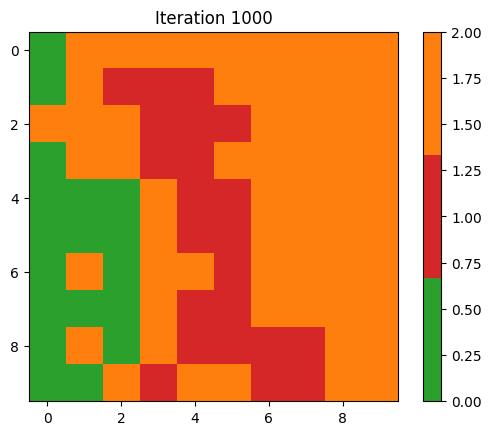

Accuracy:  0.8333333333333334
Experiment 3:
	Map Size: 15
	Max Learning Rate: 0.5
	Number of Iterations: 1000
	Sigma_0: 3
SOM training completed


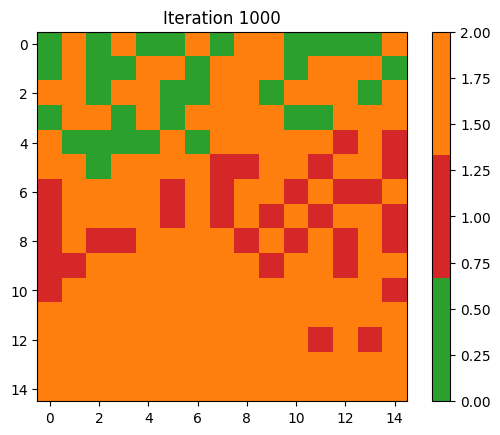

Accuracy:  0.6666666666666666
Experiment 4:
	Map Size: 5
	Max Learning Rate: 0.1
	Number of Iterations: 1000
	Sigma_0: 3
SOM training completed


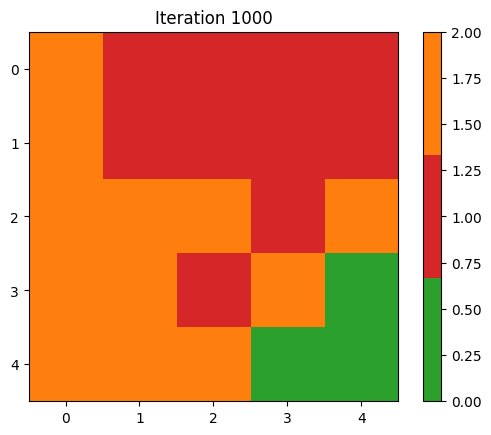

Accuracy:  0.9333333333333333
Experiment 5:
	Map Size: 5
	Max Learning Rate: 0.01
	Number of Iterations: 1000
	Sigma_0: 3
SOM training completed


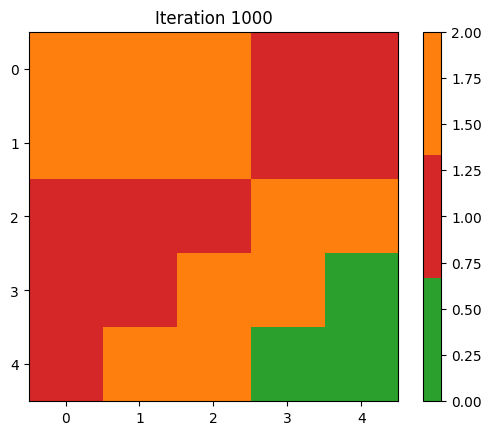

Accuracy:  0.9666666666666667
Experiment 6:
	Map Size: 5
	Max Learning Rate: 0.5
	Number of Iterations: 5000
	Sigma_0: 3
SOM training completed


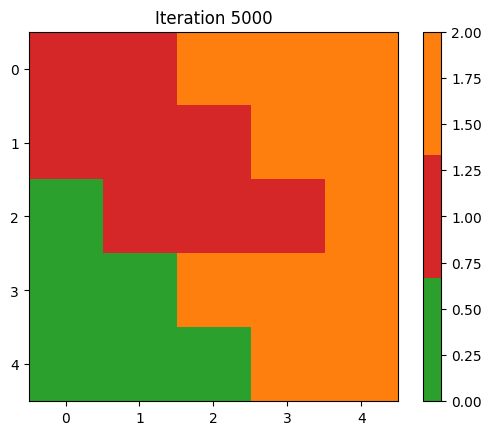

Accuracy:  0.9666666666666667
Experiment 7:
	Map Size: 5
	Max Learning Rate: 0.5
	Number of Iterations: 10000
	Sigma_0: 3
Iteration:  10000
SOM training completed


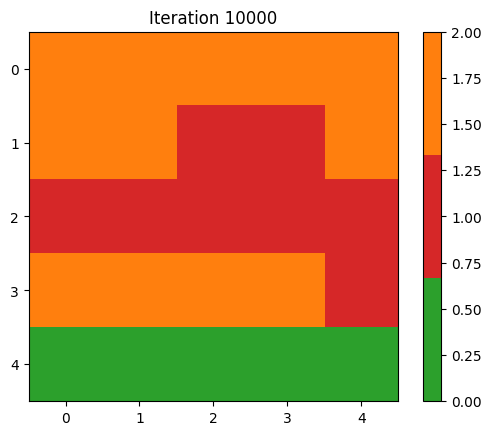

Accuracy:  0.9333333333333333
Experiment 8:
	Map Size: 5
	Max Learning Rate: 0.5
	Number of Iterations: 30000
	Sigma_0: 3
Iteration:  10000
Iteration:  20000
Iteration:  30000
SOM training completed


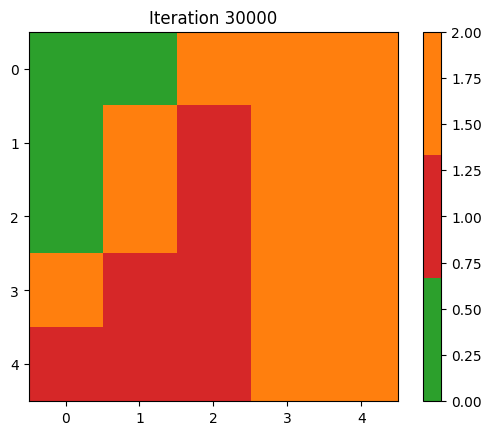

Accuracy:  1.0
Experiment 9:
	Map Size: 5
	Max Learning Rate: 0.5
	Number of Iterations: 50000
	Sigma_0: 3
Iteration:  10000
Iteration:  20000
Iteration:  30000
Iteration:  40000
Iteration:  50000
SOM training completed


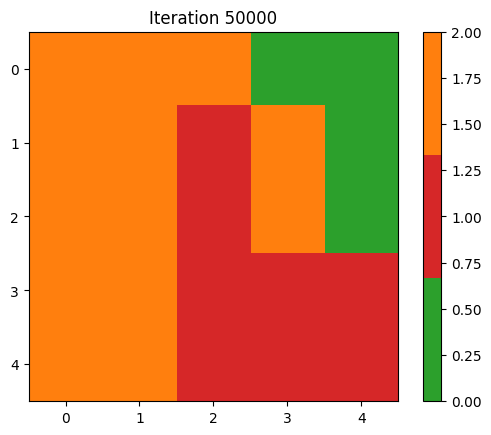

Accuracy:  0.9333333333333333
Experiment 10:
	Map Size: 5
	Max Learning Rate: 0.5
	Number of Iterations: 1000
	Sigma_0: 5
SOM training completed


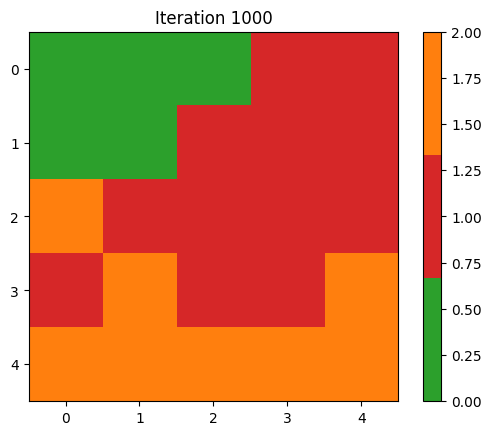

Accuracy:  0.9333333333333333
Experiment 11:
	Map Size: 5
	Max Learning Rate: 0.5
	Number of Iterations: 1000
	Sigma_0: 7
SOM training completed


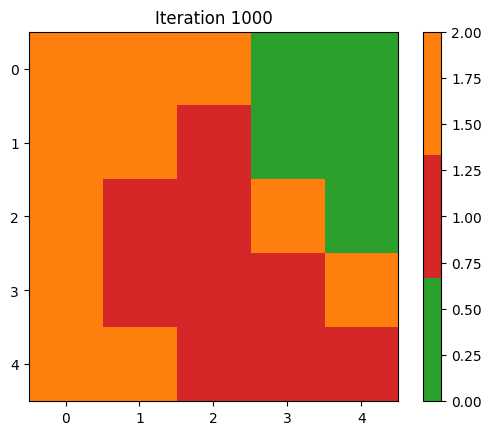

Accuracy:  0.9333333333333333


In [10]:
# experimento 0

experiments = [
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 3},
    {'map_size': 10, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 3},
    {'map_size': 15, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.1, 'n_iterations': 1000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.01, 'n_iterations': 1000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 5000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 10_000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 30_000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 50_000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 5},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 7}
]

for i, experiment in enumerate(experiments):
    print(f"Experiment {i+1}:")
    print(f"\tMap Size: {experiment['map_size']}")
    print(f"\tMax Learning Rate: {experiment['max_learning_rate']}")
    print(f"\tNumber of Iterations: {experiment['n_iterations']}")
    print(f"\tSigma_0: {experiment['sigma_0']}")

    map_size = experiment['map_size']
    max_learning_rate = experiment['max_learning_rate']
    n_iterations = experiment['n_iterations']
    sigma_0 = experiment['sigma_0']

    som, train_x_norm = train(train_x, map_size, max_learning_rate, n_iterations, sigma_0, show_progress_each=10000)
    map = collect_labels(train_y, map_size, train_x_norm, som)
    label_map = get_label_map(map_size, map)
    show_label_map(label_map, n_iterations)
    accuracy(test_x, som, map_size, label_map)